# Code development notebook

Generates weaving draft from tie-up, threading, and treadling patterns.

Black threads represent a warp-face intersection, white represents weft-face intersection.

See [Lauren Nishizaki's implementation](https://observablehq.com/@lemonnish/generate-a-weaving-draft#cell-158) for a very clear explanation and illustration of the four components of the weaving draft.

Plain weave:


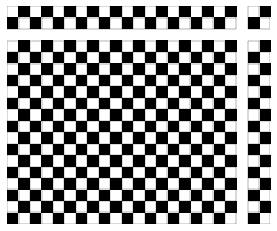

3x1 twill:


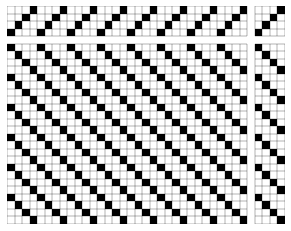

2x2 twill (straight threading):


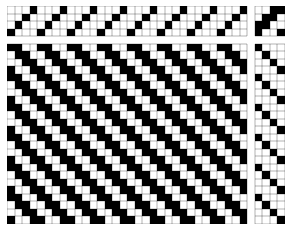

2x2 twill (herringbone threading):


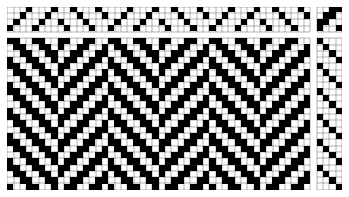

In [65]:
import numpy as np
from matplotlib import pyplot as plt
from skimage import util

# Create all plots as greyscale; else the default will be viridis.
plt.gray()


def inv(img_array):
    """ 
    This encoding represents a white cell as 0 and a black cell as 1, but by default, 
    skimage displays 0 as black and 1 as white. This functions inverts those values for display.

    Arg:
        img_array: np array representing image 
    Returns:
        np array of the same dimensions as img_array with colours inverted
    """
    return util.invert(img_array)


def display_fabric(fabric_array):
    """
    Uses matplotlib to display image.

    Arg:
        fabric_array: np array representing the generated fabric (0s and 1s)
    Returns:
        Nothing, displays image.
    """
    plt.axis('off')
    plt.imshow(inv(fabric_array))


def gen_bool_array(numbered_array):
    """
    Transforms a provided array containing numbered treadles or harnesses into a two-dimensional boolean array
    (useful for displaying).

    Arg:
        numbered_array: numpy array, either of arrays (for treadling) or integers (for threading)
    Returns:
        Array of arrays; for every weft row, one inner array, each containing 0 (not active)/1 (active) for every treadle.
    """
    # Find max value and add 1; this is how many treadles there are
    n_treadles = numbered_array.max() + 1

    # Init list that will contain the 0/1 values for each row.
    bool_treadle = []

    # Iterate through treadle_array.
    for curr_treadles in numbered_array:
        
        # Create zero array of length n_treadles.
        bool_row = np.zeros(n_treadles)

        # Replace the zeroes with ones at indices given in curr_treadles and append to accumulator list.
        np.put(bool_row, curr_treadles, 1)
        bool_treadle.append(bool_row)
    
    return np.array(bool_treadle)


def display_threading(thread_spec):
    """
    Arg:
        thread_spec: np array; integer values represent harness of each thread.
    Returns:
        Nothing, displays image.
    """
    plt.imshow(inv(np.rot90(gen_bool_array(thread_spec))))


def display_treadling(treadle_spec):
    """ 
    Arg:
        treadle_spec: np array of arrays; outer arrays = weft row, inner arrays = integer values representing active treadles.
    Returns:
        Nothing, displays image.
    """
    plt.imshow(inv(gen_bool_array(treadle_spec)))


def display_tieup(tieup_spec):
    """
    Arg:
        tieup_spec: np array of arrays; outer arrays = harnesses bottom to top, inner arrays = bool values indicating tie-up to treadles.
    Returns:
        Nothing, displays image.
    """
    plt.imshow(inv(np.flip(tieup_spec, axis=0)))


def gen_fabric(tieup_spec, treadle_spec, thread_spec):
    """
    Uses provided tie-up, treadling, and threading to genereate the resulting fabric.

    Args:
        tieup_spec: np array of arrays; outer arrays = harnesses bottom to top, inner arrays = bool values indicating tie-up to treadles.
        treadle_spec: np array of arrays; outer arrays = weft row, inner arrays = integer values representing active treadles.
        thread_spec: np array; integer values represent harness of each thread.
    Returns:
        np array of shape (len(treadle_spec), len(thread_spec)) with values 0 (weft-face) and 1 (warp-face)
    """

    # Check that the dimensions are all compatible: 
    # n rows in tieup = max+1 of thread_spec.
    n_harnesses = thread_spec.max() + 1
    assert n_harnesses == tieup_spec.shape[0], "Number of rows in tie-up don't match number of harnesses"

    # n columns in tieup = max+1 of treadle_spec.
    n_treadles = treadle_spec.max() + 1
    assert n_treadles == tieup_spec.shape[1], "Number of columns in tie-up don't match number of treadles"

    # Get the number of weft picks and warp ends in the fabric.
    n_weft = len(treadle_spec)
    n_warp = len(thread_spec)

    # Init drawdown array filled with zeroes.
    drawdown = np.zeros((n_weft, n_warp))

    # Iterate through elements of outer array (i.e., weft rows), and then through
    # elements of inner array (i.e., warp ends).

    for row_idx in range(n_weft):
        for end_idx in range(n_warp):

            # Get the harness through which the current end is threaded; an int.
            curr_harness = thread_spec[end_idx]

            # Check in the tie-up which treadles are tied to this harness.
            this_harness_tie_up = tieup_spec[curr_harness]
            tied_up_treadles = np.nonzero(this_harness_tie_up)[0]

            # Check whether any of these treadles are contained in current treadling.
            curr_treadling = treadle_spec[row_idx]

            # If the intersection of elements in this array is >0 (i.e., there's overlap between tie-up and current treadling),
            # then the current warp thread is lifted, so we should assign this cell in drawdown a 1.
            treadle_intersect = np.intersect1d(tied_up_treadles, curr_treadling)
            if len(treadle_intersect) != 0:
                drawdown[row_idx, end_idx] = 1

    return drawdown


def display_full_draft(tieup_spec, treadle_spec, thread_spec, n_pixel_sep=1, overlay_grid=True, filename=None):
    """
    Generates fabric based on provided tie-up, treadling, and threading. 
    Combines these four components into a traditionally-formatted weaving draft.
    If filename not None, saves as pdf in the provided location.

    Args:
        tieup_spec: np array of arrays; outer arrays = harnesses bottom to top, inner arrays = bool values indicating tie-up to treadles.
        treadle_spec: np array of arrays; outer arrays = weft row, inner arrays = integer values representing active treadles.
        thread_spec: np array; integer values represent harness of each thread.
        n_pixel_sep: int, the number of pixels as whitespace padding between each rectangle in draft (default 1)
        overlay_grid: bool, whether or not to include pixel grid (default True)
        filename: string ending in '.pdf', the desired filename (potentially incl. full path) to save the draft under (default None)
    Returns:
        Nothing, displays image and, if filename not None, saves image in provided path.
    """
    # Generate the upper part of the draft by combining threading, padding, and tie-up.
    padding_upper = np.zeros((tieup_spec.shape[0], n_pixel_sep))
    thread_bool = np.rot90(gen_bool_array(thread_spec))
    tieup_bool = np.flip(tieup_spec, axis=0)
    upper = np.column_stack([thread_bool, padding_upper, tieup_bool])

    # Generate the second "row" by generating fabric drawdown and combining it with tall padding and treadling.
    padding_lower = np.zeros((len(treadle_spec), n_pixel_sep))
    fabric_bool = gen_fabric(tieup_spec, treadle_spec, thread_spec)
    treadle_bool = gen_bool_array(treadle_spec)
    lower = np.column_stack([fabric_bool, padding_lower, treadle_bool])

    # Ensure that both rows have same width.
    assert upper.shape[1] == lower.shape[1], 'Upper and lower rows do not have same width'

    # Stack the two rows and put wide padding in between.
    padding_wide = np.zeros((n_pixel_sep, upper.shape[1]))
    draft = np.row_stack([upper, padding_wide, lower])

    # Now the display code.
    plt.axis('off')
    plt.imshow(inv(draft))

    # Messy code for plotting gridlines over each of the components individually (that is, not over padding)
    if overlay_grid:

        # Threading grid
        thread_rows, thread_cols = thread_bool.shape
        for row_idx in range(thread_rows+1):
            # only subtracting 3.5 from xmax here so that hline is long enough to create corner at top right
            plt.hlines(y = row_idx - 0.5, xmin = -0.5, xmax = thread_cols - 0.5, color='black', linewidth=0.3)
        for col_idx in range(thread_cols+1):
            plt.vlines(x = col_idx - 0.5, ymin = -0.5, ymax = thread_rows - 0.5, color='black', linewidth=0.3)

        # Tie-up grid
        tieup_rows, tieup_cols = tieup_bool.shape
        tieup_start_x = thread_bool.shape[1] + n_pixel_sep  # offset
        for row_idx in range(tieup_rows+1):
            # subtracting 0.64 from xmin and 0.35 from xmax instead of 0.5 to get square corners at bottom edges
            plt.hlines(y = row_idx - 0.5, xmin = tieup_start_x - 0.5, xmax = tieup_start_x + tieup_cols - 0.5, color='black', linewidth=0.3)
        for col_idx in range(tieup_start_x, tieup_start_x + tieup_cols+1):
            plt.vlines(x = col_idx - 0.5, ymin = -0.5, ymax = tieup_rows - 0.5, color='black', linewidth=0.3)

        # Fabric grid
        fabric_rows, fabric_cols = fabric_bool.shape
        fabric_start_y = thread_bool.shape[0] + n_pixel_sep # offset
        for row_idx in range(fabric_start_y, fabric_start_y + fabric_rows+1):
            # only subtracting 3.5 from xmax here so that hline is long enough to get square corner at top right
            plt.hlines(y = row_idx - 0.5, xmin = -0.5, xmax = fabric_cols - 0.5, color='black', linewidth=0.3)
        for col_idx in range(fabric_cols+1):
            plt.vlines(x = col_idx - 0.5, ymin = fabric_start_y-0.5, ymax = fabric_start_y + fabric_rows - 0.5, color='black', linewidth=0.3)

        # Treadling grid
        treadle_rows, treadle_cols = treadle_bool.shape
        treadle_start_x =  fabric_bool.shape[1] + n_pixel_sep  # offset
        treadle_start_y = thread_bool.shape[0] + n_pixel_sep   # offset
        for row_idx in range(treadle_start_y, treadle_start_y + treadle_rows+1):
            # subtracting 0.64 from xmin and 0.35 from xmax instead of 0.5 to get square corners at bottom edges
            plt.hlines(y = row_idx - 0.5, xmin = treadle_start_x - 0.5, xmax =treadle_start_x + treadle_cols - 0.5, color='black', linewidth=0.3)
        for col_idx in range(treadle_start_x, treadle_start_x + treadle_cols+1):
            plt.vlines(x = col_idx - 0.5, ymin = treadle_start_y-0.5, ymax = treadle_start_y + treadle_rows - 0.5, color='black', linewidth=0.3)

    if filename != None:
        # Saving img as pdf gives best result; rasterised image formats don't align 
        # the hlines and vlines with the cells very nicely.
        assert filename.endswith('.pdf'), 'Please provide a filename with a .pdf extension, e.g., "myfile.pdf".'
        plt.savefig(filename, dpi=300, bbox_inches='tight')
    
    plt.show()


if __name__ == '__main__':
    print('Plain weave:')
    pw_tieup = np.array([[1, 0], [0, 1]])
    # The number at the end of this variable means that the straight treadling is for 2 treadles,
    # and the straight threading is for 2 harnesses.
    straight_treadle_2 = np.array([[1], [0]] * 8)
    straight_thread_2 = np.array([0, 1] * 10)
    display_full_draft(pw_tieup, straight_treadle_2, straight_thread_2)
    
    print("3x1 twill:")
    twill3x1_tieup = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])
    straight_treadle_4 = np.array([[0], [1], [2], [3]] * 6)
    straight_thread_4 = np.array([0, 1, 2, 3] * 8)
    display_full_draft(twill3x1_tieup, straight_treadle_4, straight_thread_4)
    
    print("2x2 twill (straight threading):")
    twill2x2_tieup = np.array([[1, 0, 0, 1], [1, 1, 0, 0], [0, 1, 1, 0], [0, 0, 1, 1]])
    # We can reuse the same straight treadling and threading from before!
    display_full_draft(twill2x2_tieup, straight_treadle_4, straight_thread_4)

    print("2x2 twill (herringbone threading):")
    herringbone_thread = np.array(np.concatenate([[0, 1, 2, 3] * 2 + [1, 0, 3, 2] * 2] * 3))
    # We can reuse the same tie-up and straight treadling as above.
    display_full_draft(twill2x2_tieup, straight_treadle_4, herringbone_thread)

# Defining tie-up

The tie-up will be represented as an array of arrays.
There is one inner array for each harness, *ordered from bottom to top* (so the array at index 0 is actually the bottom one in the schematic diagram).
Each inner array contains one element per treadle, ordered from left to right (i,e., each column of the outer array represents one treadle).
Each element in the inner array is either a 0 or 1; 0 represents that the given treadle is not tied up to the given harness (typically shown as white on a tie-up diagram), and 1 represents that the given treadle is ttied up to the given harness (typically shown as black).

Thus, the tie-up for plain weave might be represented as:

```
[[1, 0],
 [0, 1]
```

What this looks like in a typical weaving draft (remember that the bottom row of the diagram is the zeroth element of the outer array):

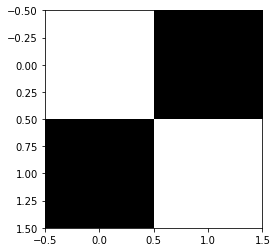

In [17]:
pw_tieup = np.array([[1, 0], [0, 1]])
display_tieup(pw_tieup)

Tie-up for 2x2 twill:

```
[[1, 0, 0, 1],
 [1, 1, 0, 0],
 [0, 1, 1, 0],
 [0, 0, 1, 1]]
```

Here it becomes clearer that the zeroth index of the outer array (i.e., first row of this array) is actually the _bottom_ row of the tie-up diagram.

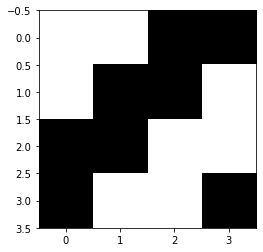

In [18]:
twill2x2_tieup = np.array([[1, 0, 0, 1], [1, 1, 0, 0], [0, 1, 1, 0], [0, 0, 1, 1]])
display_tieup(twill2x2_tieup)

# Defining treadling

The treadling will be represented as an array of arrays.
Each inner array represents a weft row, ordered from top to bottom.
Each inner array contains which treadles are pressed down on that row.

Plain weave treadling of 6 rows:

```
[[1],
 [0],
 [1],
 [0],
 [1],
 [0]]
```

In a typical weaving draft:


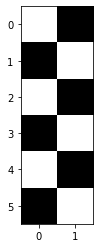

In [19]:
pw_treadle = np.array([[1], [0], [1], [0], [1], [0]])
display_treadling(pw_treadle)

2x2 twill treadling with 12 rows:

```
[[0],
 [1],
 [2],
 [3],
 [0],
 [1],
 [2],
 [3],
 [0],
 [1],
 [2],
 [3]]
```

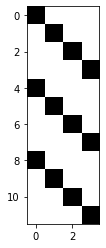

In [20]:
twill2x2_treadle = np.array([[0], [1], [2], [3], [0], [1], [2], [3], [0], [1], [2], [3]])
display_treadling(twill2x2_treadle)

The same 2x2 twill treadling, but with the opposite treadles pushed down (to show that the code can handle multiple treadles per row):

```
[[1, 2, 3],
 [0, 2, 3],
 [0, 1, 3],
 [0, 1, 2],
 [1, 2, 3],
 [0, 2, 3],
 [0, 1, 3],
 [0, 1, 2],
 [1, 2, 3],
 [0, 2, 3],
 [0, 1, 3],
 [0, 1, 2]]
```

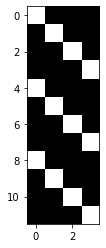

In [21]:
twill2x2_treadle_opp = np.array([[1, 2, 3], [0, 2, 3], [0, 1, 3], [0, 1, 2], [1, 2, 3], [0, 2, 3], [0, 1, 3], [0, 1, 2], [1, 2, 3], [0, 2, 3], [0, 1, 3], [0, 1, 2]])
display_treadling(twill2x2_treadle_opp)

# Defining the threading

The third and final piece of information required for generating the draw-down is the threading.
Since each warp thread (i.e., each _end_) can only go through one harness, the threading will be encoded as a one-dimensional array containing at each index the harness that the thread of that index goes through, from left to right.

Plain weave threading with 8 ends:

```
[0, 1, 0, 1, 0, 1, 0, 1]
```

In a typical weaving draft:

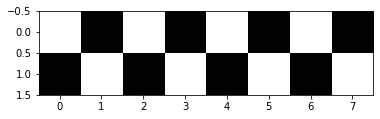

In [22]:
pw_thread = np.array([0, 1, 0, 1, 0, 1, 0, 1])
display_threading(pw_thread)

2x2 twill threading with 16 ends:

```
[0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3]
```

In a typical weaving draft:

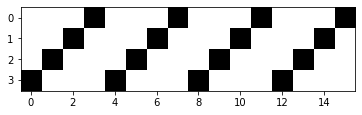

In [23]:
twill2x2_thread = np.array([0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3])
display_threading(twill2x2_thread)

# The fabric draw-down

The fabric is generated as a function of the tie-up, treadling, and threading.

- Generate a zero array of shape `(n_weft, n_warp)` where `n_weft` is the number of elements in the treadling specification, and `n_warp` the number of elements in the threading specification.
- For `row_idx` of outer array:
- For `end_idx` of inner array:
- get treadling at `row_idx` (array of ints) and threading at `end_idx` (int)
- get the int of the threading (i.e. the harness), and look at what treadle(s) that harness is tied to
- check if any of those treadles are activated (i.e., in the current treadling). if they are, then replace the value in the current cell `(row_idx, end_idx)` with 1.

## Plain weave

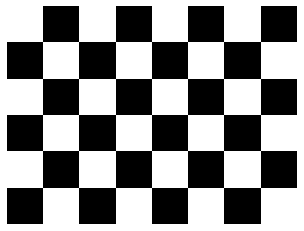

In [24]:
pw_fabric = gen_fabric(pw_tieup, pw_treadle, pw_thread) 
display_fabric(pw_fabric)

## 2x2 twill

First up, straight threading.

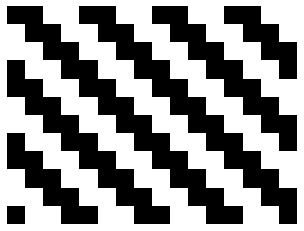

In [25]:
twill2x2_fabric = gen_fabric(twill2x2_tieup, twill2x2_treadle, twill2x2_thread) 
display_fabric(twill2x2_fabric)

### Herringbone

All that changes between the 2x2 twill above and herringbone is the threading.

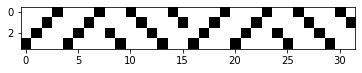

In [26]:
herringbone_thread = np.array([0, 1, 2, 3]*2 + [1, 0, 3, 2]*2 + [0, 1, 2, 3]*2 + [1, 0, 3, 2]*2)

# Display threading
display_threading(herringbone_thread)

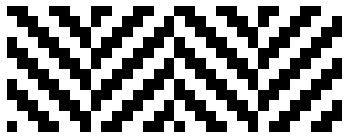

In [27]:
twill2x2_fabric = gen_fabric(twill2x2_tieup, twill2x2_treadle, herringbone_thread) 
display_fabric(twill2x2_fabric)

# 3x1 twill

Straight threading and treadling

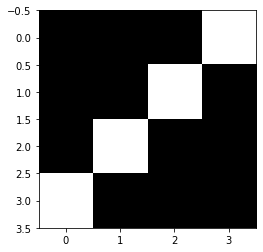

In [28]:
twill3x1_tieup = np.array([[0,1,1,1], [1,0,1,1], [1,1,0,1], [1,1,1,0]])

display_tieup(twill3x1_tieup)

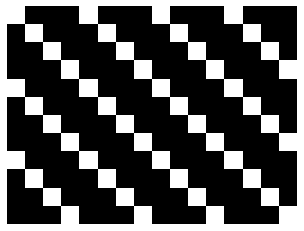

In [29]:
twill3x1_fabric = gen_fabric(twill3x1_tieup, twill2x2_treadle, twill2x2_thread)
display_fabric(twill3x1_fabric)

Zigzag threading, straight treadling

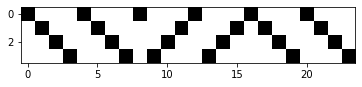

In [30]:
zigzag_thread = np.array([3,2,1,0]*2 + [3] + [0,1,2,3]*2 + [2,1,0] + [3,2,1,0])

display_threading(zigzag_thread)

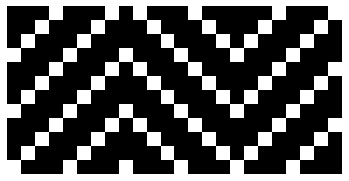

In [31]:
twill3x1_fabric = gen_fabric(twill3x1_tieup, twill2x2_treadle, zigzag_thread)
display_fabric(twill3x1_fabric)

Zigzag threading and treadling a la https://www.pinterest.com/pin/351562314662796215/ 


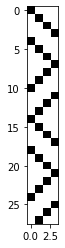

In [32]:
zigzag_treadle = np.array([[0], [1], [2], [3], [ 0], [1], [2], [3], [ 2], [1], [0], [ 3], [2], [1], [ 0], [1], [2], [3], [ 0], [1], [2], [3], [ 2], [1], [0], [ 3], [2], [1]])
display_treadling(zigzag_treadle)

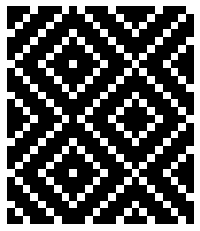

In [33]:
twill3x1_fabric = gen_fabric(twill3x1_tieup, zigzag_treadle, zigzag_thread)
display_fabric(twill3x1_fabric)

# Display full weaving draft

We'll need to combine arrays with threading and tie-up on top, and fabric drawdown and treadling below.
Separated by `n` white pixels.

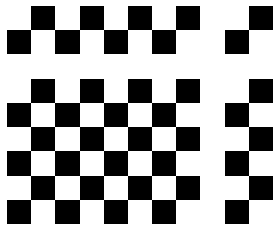

In [34]:
display_full_draft(pw_tieup, pw_treadle, pw_thread, overlay_grid=False, n_pixel_sep=1)

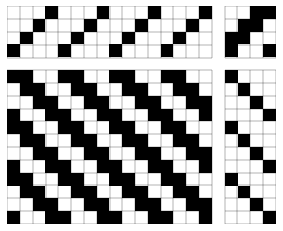

In [35]:
display_full_draft(twill2x2_tieup, twill2x2_treadle, twill2x2_thread, overlay_grid=True)

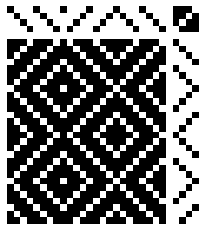

In [36]:
display_full_draft(twill3x1_tieup, zigzag_treadle, zigzag_thread, overlay_grid=False)

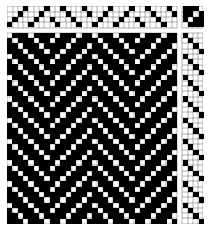

In [37]:
# display_full_draft(twill3x1_tieup, zigzag_treadle, herringbone_thread, overlay_grid=False)
display_full_draft(twill3x1_tieup, np.concatenate([twill2x2_treadle]*3), herringbone_thread, filename='sample_drafts/3x1_herringbone.pdf')#, overlay_grid=False)

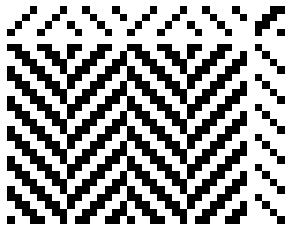

In [38]:
display_full_draft(twill2x2_tieup, zigzag_treadle, herringbone_thread, overlay_grid=False)
display_full_draft(twill2x2_tieup, np.concatenate([twill2x2_treadle]*2), herringbone_thread, overlay_grid=False)

Encoding a new draft from scratch: hearts https://www.pinterest.com/pin/782289397795848743 

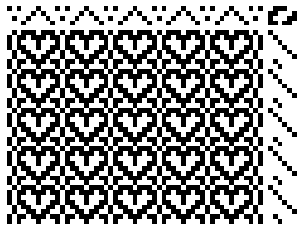

In [39]:
hearts_tieup = np.array([
    [1,1,0,1,1,0],
    [1,0,0,0,1,1],
    [1,1,0,0,0,1],
    [0,1,1,1,0,0]])

hearts_treadle_rep = np.array([
    [0],
    [1],
    [2],
    [3],
    [4],
    [5],
    [1],
    [2]])

hearts_thread_rep = np.array([3, 1, 3, 0, 1, 2, 3, 2, 1, 0])
hearts_thread_sfx = np.array([3, 1, 3])

display_full_draft(hearts_tieup, 
                    np.concatenate([hearts_treadle_rep]*5), 
                    np.concatenate([hearts_thread_rep]*5 + [hearts_thread_sfx]), 
                    overlay_grid=False)

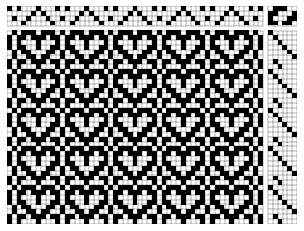

In [40]:
display_full_draft(hearts_tieup, 
                    np.concatenate([hearts_treadle_rep]*5), 
                    np.concatenate([hearts_thread_rep]*5 + [hearts_thread_sfx]), 
                    overlay_grid=True)